# Ch 5. Model Comparison

1. Posterior predictive checks
2. Occam's razor—simplicity and accuracy
3. Overfitting and underfitting
4. Information criteria
5. Bayes factors
6. Regularizing priors

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as gg

## Posterior predictive checks (PPC)

- a way to evalutate a model in the context of the purpose of the model
- with multiple models, can use PPC to compare them

In [22]:
dummy_data.x.std()

1.5152251489115205

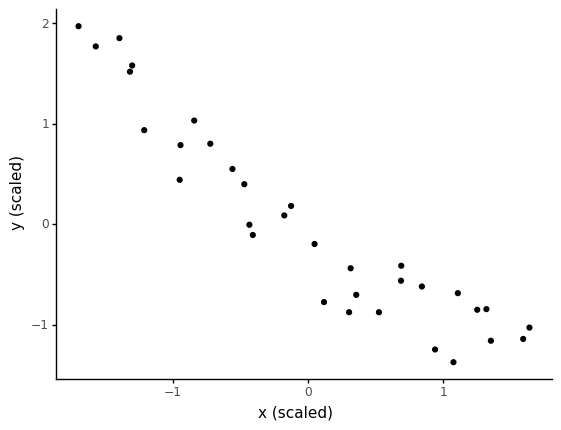

<ggplot: (309953588)>

In [71]:
dummy_data = pd.DataFrame(np.loadtxt("data/dummy.csv"), columns=["x_1", "y"])

dummy_data = dummy_data.assign(
    x_1s=lambda df: (df.x_1 - df.x_1.mean()) / df.x_1.std(),
    x_2s=lambda df: df.x_1s ** 2,
    y_s=lambda df: (df.y - df.y.mean()) / df.y.std(),
)

(
    gg.ggplot(dummy_data, gg.aes("x_1s", "y_s"))
    + gg.geom_point()
    + gg.theme_classic()
    + gg.labs(x="x (scaled)", y="y (scaled)")
)

- example: compare linear and polynomial data

In [72]:
with pm.Model() as model_l:
    alpha = pm.Normal("alpha", mu=0, sd=1)
    beta = pm.Normal("beta", mu=0, sd=10)
    epsilon = pm.HalfNormal("epsilon", 5)

    mu = alpha + beta * dummy_data["x_1s"]

    y_pred = pm.Normal("y_pred", mu=mu, sd=epsilon, observed=dummy_data["y_s"])
    trace_l = pm.sample(2000)
    postpredcheck_l = pm.sample_posterior_predictive(trace_l, 2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, beta, alpha]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 15 seconds.
/Users/admin/Developer/Python/bayesian-analysis-with-python_e2/.env/lib/python3.8/site-packages/pymc3/sampling.py:1617: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample


In [73]:
az_l = az.from_pymc3(trace=trace_l, model=model_l, posterior_predictive=postpredcheck_l)

arviz.data.io_pymc3 - WARNING - posterior predictive variable y_pred's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


In [74]:
with pm.Model() as model_p:
    alpha = pm.Normal("alpha", mu=0, sd=1)
    beta = pm.Normal("beta", mu=0, sd=10, shape=2)
    epsilon = pm.HalfNormal("epsilon", 5)

    mu = alpha + pm.math.dot(beta, dummy_data[["x_1s", "x_2s"]].to_numpy().T)

    y_pred = pm.Normal("y_pred", mu=mu, sd=epsilon, observed=dummy_data["y_s"])
    trace_p = pm.sample(2000)
    postpredcheck_p = pm.sample_posterior_predictive(trace_p, 2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, beta, alpha]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 15 seconds.
/Users/admin/Developer/Python/bayesian-analysis-with-python_e2/.env/lib/python3.8/site-packages/pymc3/sampling.py:1617: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample


In [75]:
az_p = az.from_pymc3(trace=trace_p, model=model_p, posterior_predictive=postpredcheck_p)

arviz.data.io_pymc3 - WARNING - posterior predictive variable y_pred's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


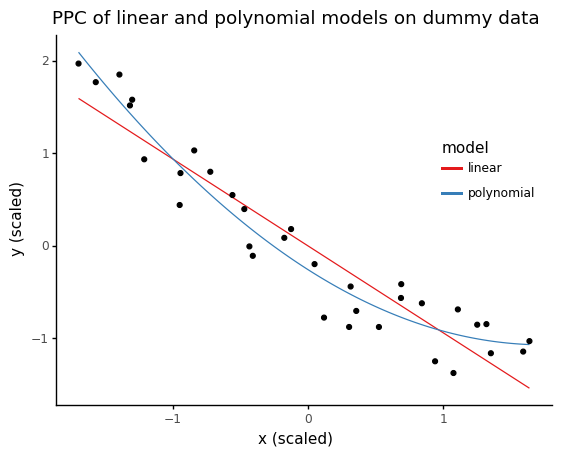

<ggplot: (309400724)>

In [76]:
x_new = np.linspace(dummy_data.x_1s.min(), dummy_data.x_1s.max(), 100)

alpha_l_post = trace_l["alpha"].mean()
beta_l_post = trace_l["beta"].mean(axis=0)
y_l_post = alpha_l_post + beta_l_post * x_new
ppc_l = pd.DataFrame({"x": x_new, "y": y_l_post, "model": "linear"})

alpha_p_post = trace_p["alpha"].mean()
beta_p_post = trace_p["beta"].mean(axis=0)
y_p_post = alpha_p_post + beta_p_post[0] * x_new + beta_p_post[1] * (x_new ** 2)
ppc_p = pd.DataFrame({"x": x_new, "y": y_p_post, "model": "polynomial"})


(
    gg.ggplot(pd.concat([ppc_l, ppc_p]))
    + gg.aes("x", "y")
    + gg.geom_line(gg.aes(color="model"))
    + gg.geom_point(gg.aes(x="x_1s", y="y_s"), data=dummy_data)
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.theme_classic()
    + gg.theme(legend_position=(0.8, 0.6))
    + gg.labs(
        x="x (scaled)",
        y="y (scaled)",
        title="PPC of linear and polynomial models on dummy data",
    )
)

## Occam's razor – simplicity and accuracy

## Information criteria

- tools for measuring how well the model fits the data given the complexity of the model

### Model comparison with PyMC3

In [81]:
az.waic(az_l)

Computed from 4000 by 33 log-likelihood matrix

          Estimate       SE
elpd_waic   -13.87     2.69
p_waic        2.47        -

The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

In [82]:
az.waic(az_p)

Computed from 4000 by 33 log-likelihood matrix

          Estimate       SE
elpd_waic    -4.10     2.35
p_waic        2.69        -

The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

In [88]:
az.compare({"linear_model": az_l, "polynomal_model": az_p})

/Users/admin/Developer/Python/bayesian-analysis-with-python_e2/.env/lib/python3.8/site-packages/arviz/stats/stats.py:150: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
polynomal_model,0,-4.13972,2.72082,0,0.998179,2.69576,0,False,log
linear_model,1,-13.8833,2.48809,9.74363,0.00182077,2.41675,2.67658,False,log


/Users/admin/Developer/Python/bayesian-analysis-with-python_e2/.env/lib/python3.8/site-packages/arviz/stats/stats.py:150: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.


<AxesSubplot:xlabel='Log'>

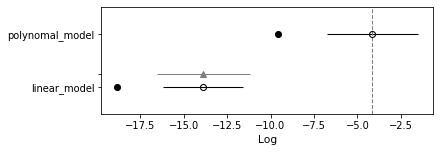

In [89]:
az.plot_compare(az.compare({"linear_model": az_l, "polynomal_model": az_p}))

## Bayes factors[sic]

- **Bayes factor**

$$
BF = \frac{\Pr(y | M_0)}{\Pr(y | M_1)}
$$

- if $BF > 1$ than model 0 is better at explaining the results than model 1
    - 1-3: weak
    - 3-10: moderate
    - 10-30: strong
    - 30-100: very strong
    - \>100: extreme
- BF are frequently criticized as  hypothesis tested
    - inference based model comparison is generally preferred

### Regularizing priors

- **regurlaization**: adding a bias to reduce a generalization error without affecting the ability of the model to fit
    - common way is to penalize larger parameter values
    - a Bayesian method is to use a tighter prior distribution
    - a Laplace distribution has a peak at 0 and can be used to introduce sparsity